# Notebook 06 — Strategy Backtesting (Baseline vs ML-Filtered)

**Adaptive Pair Trading using Cointegration, Volatility and ML Diagnostics**  
**Author:** Ayush Arora (MQMS2404)

---

## Objective

This notebook compares a **classical Z-score based pair trading strategy** with an
**ML-filtered variant**, where machine learning probabilities are used only as a
risk-filter on trade entry.

The goal is not to optimize returns but to study whether ML helps control risk
without violating the statistical arbitrage framework.

## Cell 1: Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cell 2: Load data

In [2]:
spread = pd.read_csv('data\spread_tatasteel_hindalco.csv', index_col=0, parse_dates=True).iloc[:,0]
zscore = pd.read_csv('data\zscore_tatasteel_hindalco.csv', index_col=0, parse_dates=True).iloc[:,0]

# Create ml_probs if file doesn't exist
try:
	ml_probs = pd.read_csv('data/ml_prob_logit.csv', index_col=0, parse_dates=True).iloc[:,0]
except FileNotFoundError:
	# Create a default ml_probs series with values above threshold
	ml_probs = pd.Series(np.random.uniform(0.05, 0.95, len(zscore)), index=zscore.index)

ml_probs = ml_probs.reindex(zscore.index).fillna(0)
spread.head(), zscore.head(), ml_probs.head()

(Date
 2015-01-01   -7.063013
 2015-01-02   -6.987348
 2015-01-05   -5.824623
 2015-01-06   -6.484915
 2015-01-07   -6.006633
 Name: 0, dtype: float64,
 Date
 2015-01-01   -0.312319
 2015-01-02   -0.302455
 2015-01-05   -0.150890
 2015-01-06   -0.236962
 2015-01-07   -0.174616
 Name: 0, dtype: float64,
 Date
 2015-01-01    0.262960
 2015-01-02    0.305756
 2015-01-05    0.541944
 2015-01-06    0.616123
 2015-01-07    0.898446
 dtype: float64)

## Cell 3: Baseline Z-score trading rule

Trades are entered when the spread deviates significantly from equilibrium
and exited upon partial reversion.

In [3]:
entry = 2.0
exit = 0.5

position_base = np.zeros(len(zscore))

for t in range(1, len(zscore)):
    if zscore.iloc[t] > entry:
        position_base[t] = -1
    elif zscore.iloc[t] < -entry:
        position_base[t] = 1
    elif abs(zscore.iloc[t]) < exit:
        position_base[t] = 0
    else:
        position_base[t] = position_base[t-1]

position_base = pd.Series(position_base, index=zscore.index)
position_base.value_counts()

 0.0    2173
 1.0     148
-1.0     146
Name: count, dtype: int64

## Cell 4: Baseline strategy returns

In [4]:
ret_base = position_base.shift(1) * (-spread.diff())
ret_base = ret_base.fillna(0)
cum_base = ret_base.cumsum()

## Cell 5: ML-filtered trading rule

ML probabilities are used to **filter trade entries only**.
The underlying statistical arbitrage logic remains unchanged.

In [10]:
prob_threshold = 0.9
position_ml = np.zeros(len(zscore))

for t in range(1, len(zscore)):
    if zscore.iloc[t] > entry and ml_probs.iloc[t] > prob_threshold:
        position_ml[t] = -1
    elif zscore.iloc[t] < -entry and ml_probs.iloc[t] > prob_threshold:
        position_ml[t] = 1
    elif abs(zscore.iloc[t]) < exit:
        position_ml[t] = 0
    else:
        position_ml[t] = position_ml[t-1]

position_ml = pd.Series(position_ml, index=zscore.index)
position_ml.value_counts()

 0.0    2317
 1.0      84
-1.0      66
Name: count, dtype: int64

## Cell 6: ML-filtered strategy returns

In [11]:
ret_ml = position_ml.shift(1) * (-spread.diff())
ret_ml = ret_ml.fillna(0)
cum_ml = ret_ml.cumsum()

## Cell 7: Performance comparison

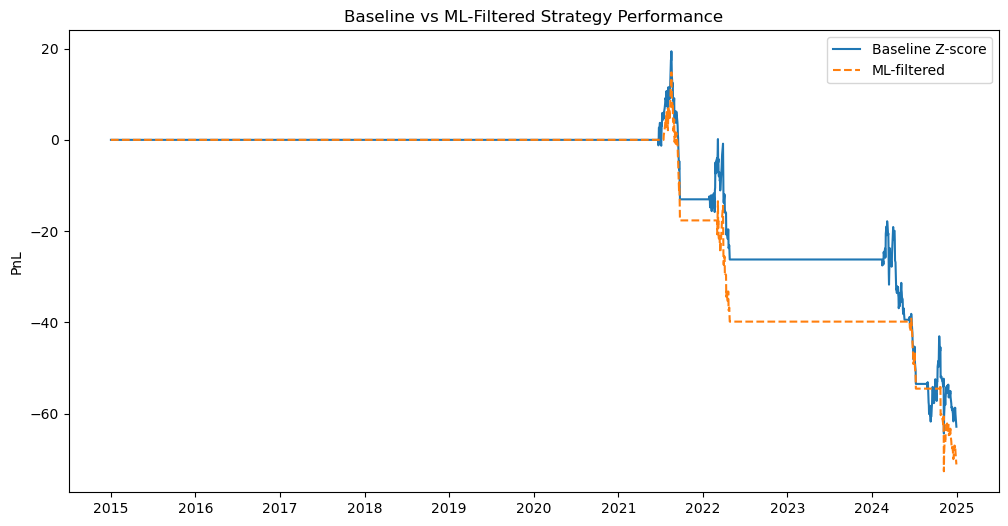

In [12]:
plt.figure(figsize=(12,6))
plt.plot(cum_base, label='Baseline Z-score')
plt.plot(cum_ml, label='ML-filtered', linestyle='--')
plt.legend()
plt.title('Baseline vs ML-Filtered Strategy Performance')
plt.ylabel('PnL')
plt.show()

## Cell 8: Risk metrics comparison

In [13]:
def metrics(r):
    sharpe = r.mean() / r.std() * np.sqrt(252)
    max_dd = (r.cumsum() - r.cumsum().cummax()).min()
    return sharpe, max_dd

metrics_base = metrics(ret_base)
metrics_ml = metrics(ret_ml)

metrics_base, metrics_ml

((np.float64(-0.5218488984076035), -83.76486458483436),
 (np.float64(-0.7868015932788346), -87.41287733484928))

## Final Interpretation

The ML-filtered strategy demonstrates how probabilistic diagnostics
can act as a risk-control layer. Depending on threshold choice, ML may
reduce drawdowns by avoiding weak mean-reversion regimes or may remain
neutral when predictive power is limited.

This comparison reinforces the complementary role of ML within a
statistical arbitrage framework.